In [1]:
from pipeline import meso,posture,treadmill
import datajoint as dj
import numpy as np
import pandas as pd
import static_nda as nda
eye = dj.create_virtual_module('pipeline_eye','pipeline_eye')
pupil = dj.create_virtual_module('pipeline_eye','pipeline_eye')

import matplotlib.pyplot as plt


Loading local settings from pipeline_config.json
Connecting pfahey@at-database.ad.bcm.edu:3306


# Eye Camera Recording Frequency

eye frequency range:  20.0  -  20.0  Hz
resolution for full facial view
image height:  632 - 906  pixels
image width:  857 - 1156  pixels

resolution for eye only view
image height:  281 - 281  pixels
image width:  365 - 381  pixels


animal_id  session  scan_idx  eye_time_len  eye_time_freq  eye_px_height  \
0       21067        9        17        121235       20.00064            806   
1       21067       10        18        124203       20.00072            826   
2       21067       13        14        132327       20.00052            632   
3       22620        4        15        123434       20.00092            770   
4       22620        4        17        129651       20.00072            770   
5       22620        5        11        122229       20.00048            770   
6       22846        2        19        120706       20.00052            890   
7       22846        2        21        138630       20.00064            890   
8       22846        7        15        120923       20.00076            788   
9       22846       10        16        121781       20.00056            764   
10      23343        5        17        120004       20.00040            664   
11      23555        5        12        121302       20.00064            756   
12      23656       14        22        121159       20.00056            906   
13      23964        4        22        119333       20.00064            774   
14      26644       14        17        150143       20.00104            281   
15      26645        2        18        148846       20.00168            281   

    eye_px_width  
0            986  
1           1014  
2            857  
3           1156  
4           1156  
5           1156  
6           1043  
7           1043  
8           1016  
9           1074  
10          1113  
11          1043  
12          1031  
13          1042  
14           381  
15           365

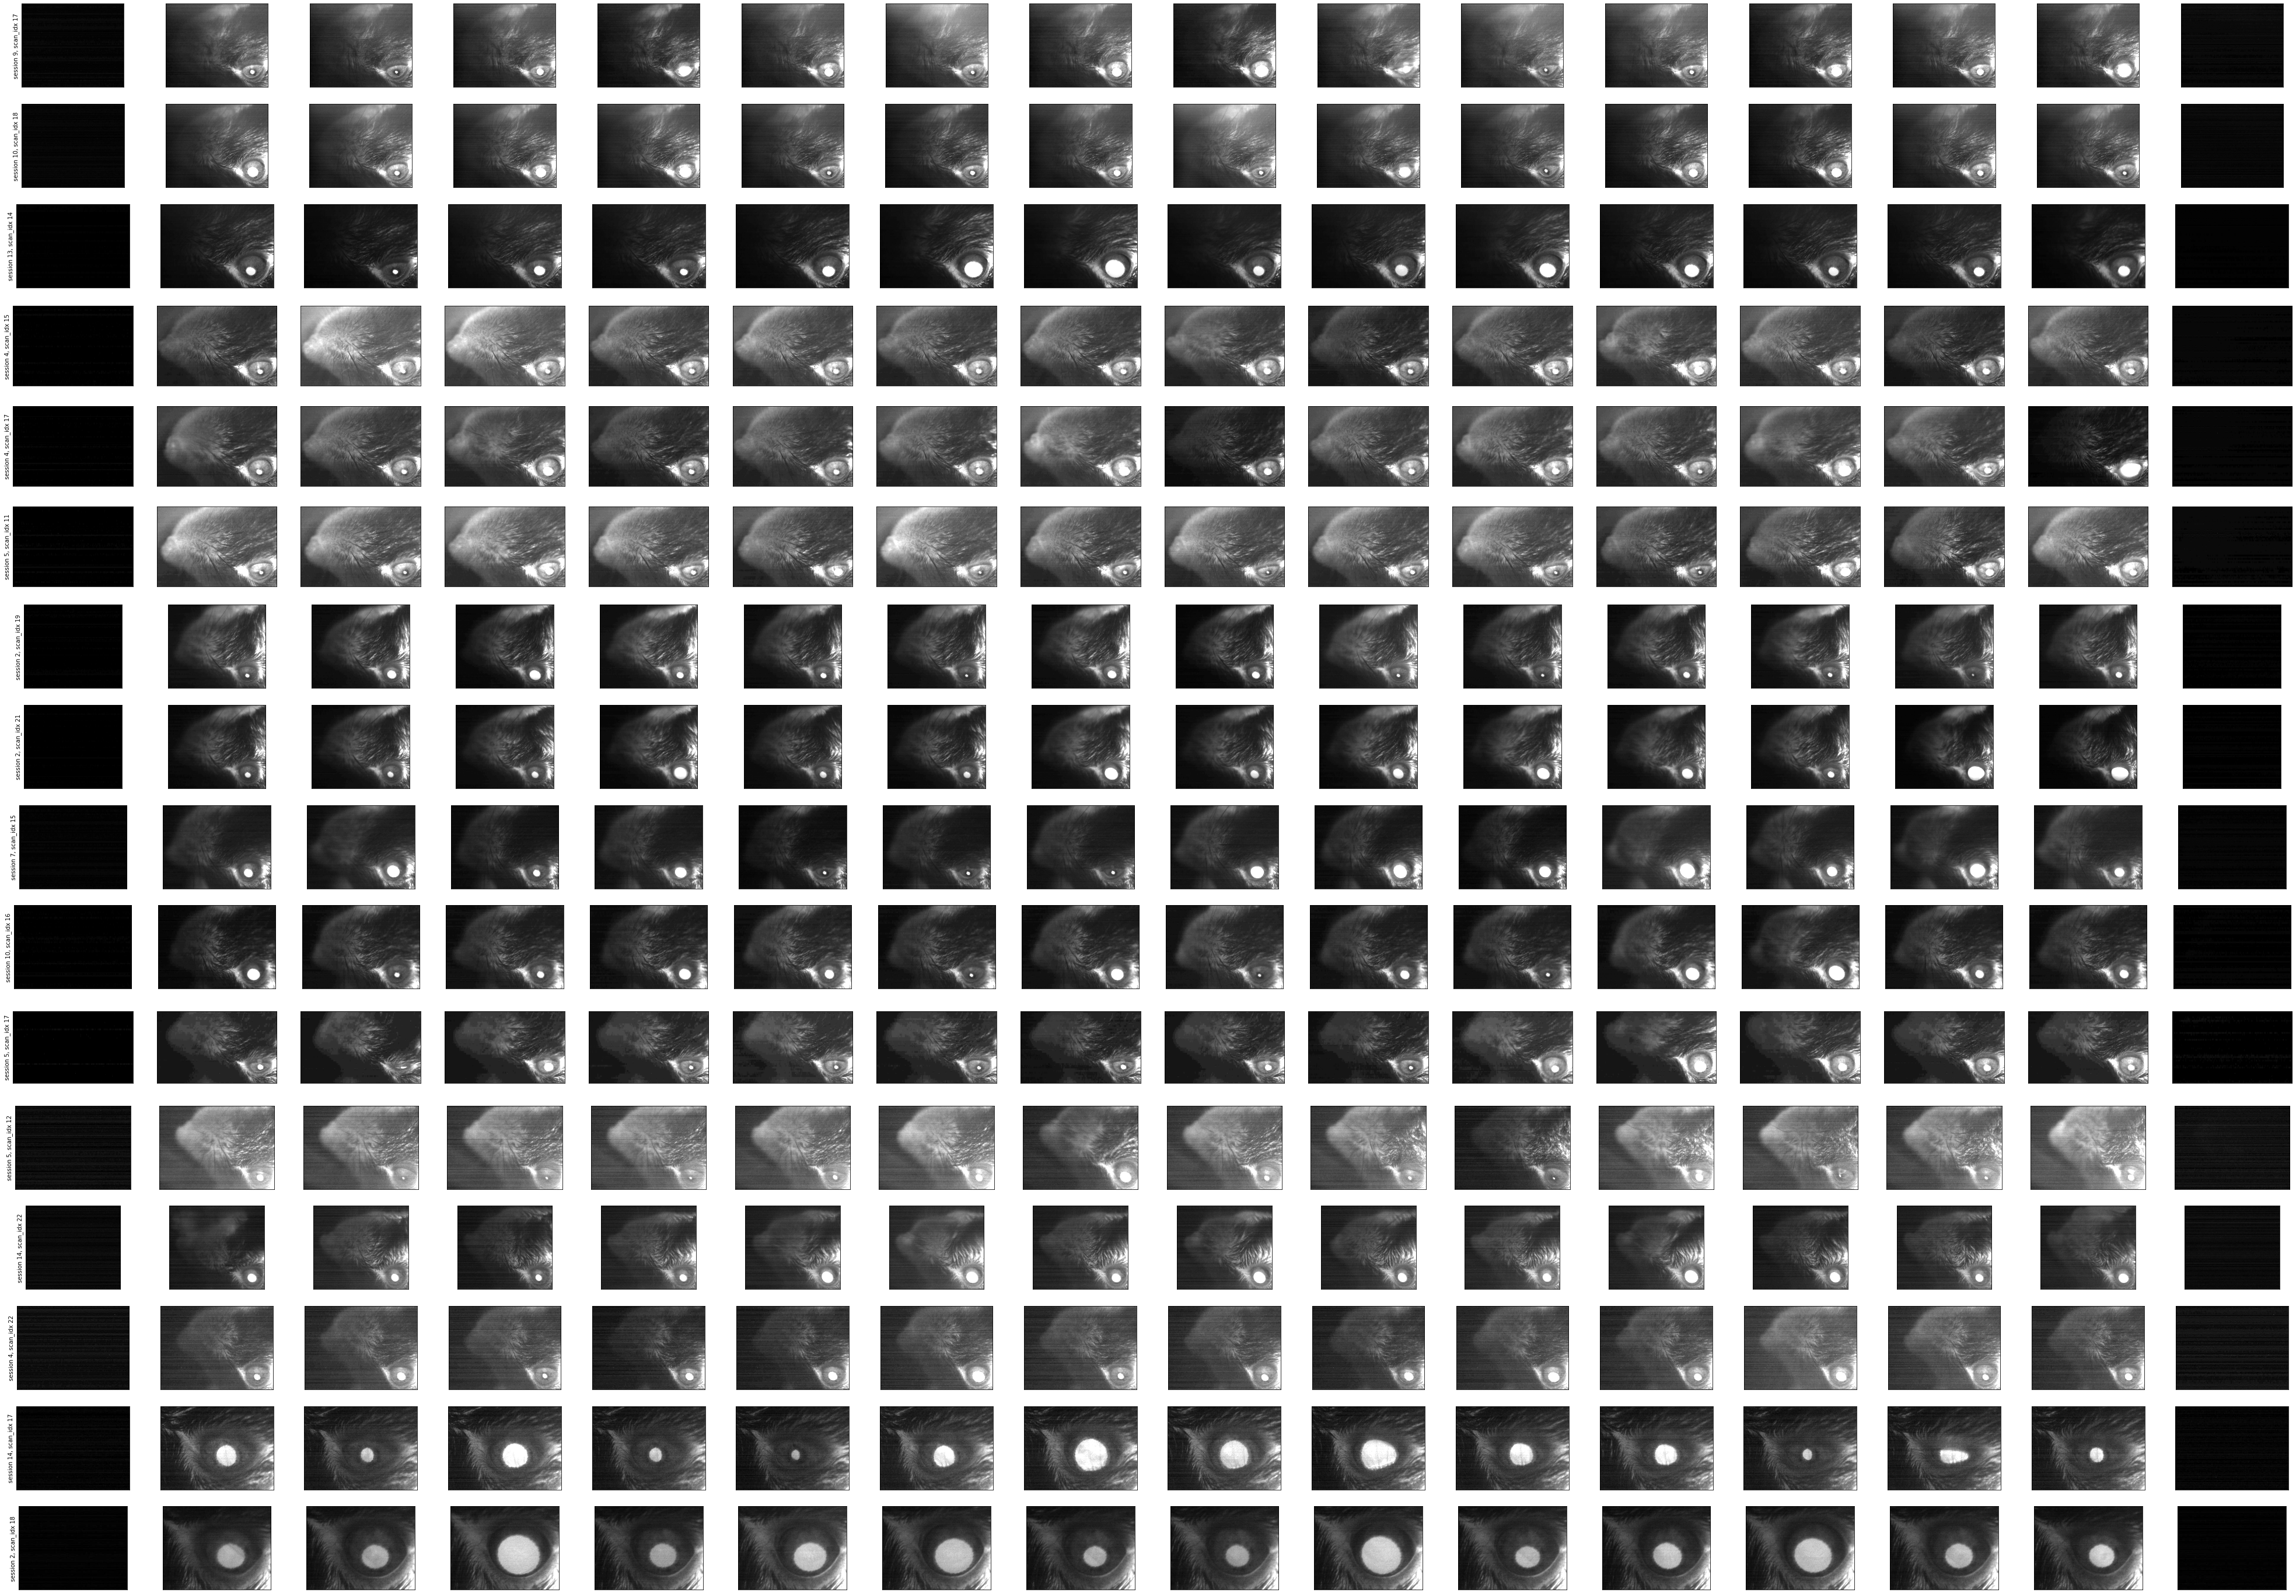

In [2]:
eye_df = []
fig,axes_set = plt.subplots(len(nda.Scan()),16,figsize=(70,50))
for scan,axes in zip(nda.Scan.proj(),axes_set):
    preview_frames = np.moveaxis((eye.Eye & scan).fetch1('preview_frames'),-1,0)
    eye_times = (eye.Eye & scan).fetch1('eye_time')
    
    for ax,f in zip(axes,preview_frames):
        ax.imshow(f,cmap='gray',vmin=np.percentile(preview_frames,1),vmax=np.percentile(preview_frames,99))
        ax.set_xticks([])
        ax.set_yticks([])

    title = ', '.join([s + ' ' + str(scan[s]) for s in ['session','scan_idx']])
    axes[0].set_ylabel(title)
    
    eye_df.append({'animal_id':scan['animal_id'],
                   'session':scan['session'],
                   'scan_idx':scan['scan_idx'],
                   'eye_time_len':len(eye_times),
                   'eye_time_freq':1/np.nanmedian(np.diff(eye_times)),
                   'eye_px_height':np.shape(preview_frames)[1],
                   'eye_px_width':np.shape(preview_frames)[2]})
eye_df = pd.DataFrame(eye_df)
print('eye frequency range: ',
      np.round(np.min(eye_df['eye_time_freq']),2), ' - ',
      np.round(np.max(eye_df['eye_time_freq']),2), ' Hz')

print('resolution for full facial view')
print('image height: ', 
      np.min(eye_df['eye_px_height'][:-2]), '-',
      np.max(eye_df['eye_px_height'][:-2]), ' pixels')
print('image width: ', 
      np.min(eye_df['eye_px_width'][:-2]), '-',
      np.max(eye_df['eye_px_width'][:-2]), ' pixels')


print('\nresolution for eye only view')
print('image height: ', 
      np.min(eye_df['eye_px_height'][-2:]), '-',
      np.max(eye_df['eye_px_height'][-2:]), ' pixels')
print('image width: ', 
      np.min(eye_df['eye_px_width'][-2:]), '-',
      np.max(eye_df['eye_px_width'][-2:]), ' pixels')

display(eye_df)


# Automatic Eye Tracking

In [37]:
fit_df = []
tracking_method_rest = 'tracking_method = 2'
for scan in nda.Scan.proj():
    ts = np.array((pupil.Eye & scan).fetch1('eye_time'))
    rs,ids,cents = (pupil.FittedPupil.Circle & scan & tracking_method_rest).fetch('radius','frame_id','center')    
    xs,ys = np.vstack([[np.nan,np.nan] if c is None else c for c in cents]).T
    ts -= np.nanmin(ts)
    ts = ts[ids]
    rs -= np.nanmin(rs)
    rs /= np.nanpercentile(rs,99.9)
    xs -= np.nanmedian(xs)
    xs /= np.nanpercentile(np.abs(xs),99.9)
    ys -= np.nanmedian(ys)
    ys /= np.nanpercentile(np.abs(ys),99.9)
    fit_df.append({'scan_label':'_'.join([str(s) for s in scan.values()]),
                   'ts':ts,
                   'rs':rs,
                   'ids':ids,
                   'xs':xs,
                   'ys':ys})
    


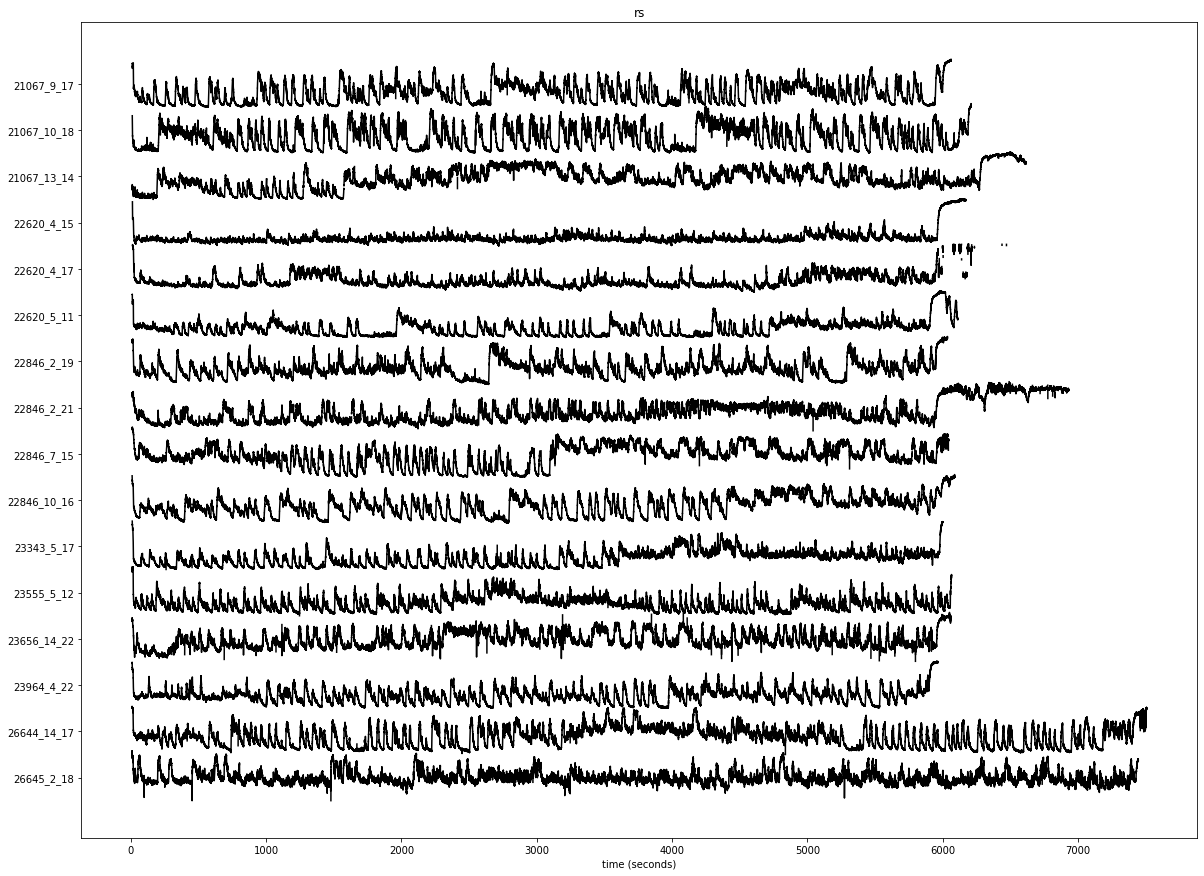

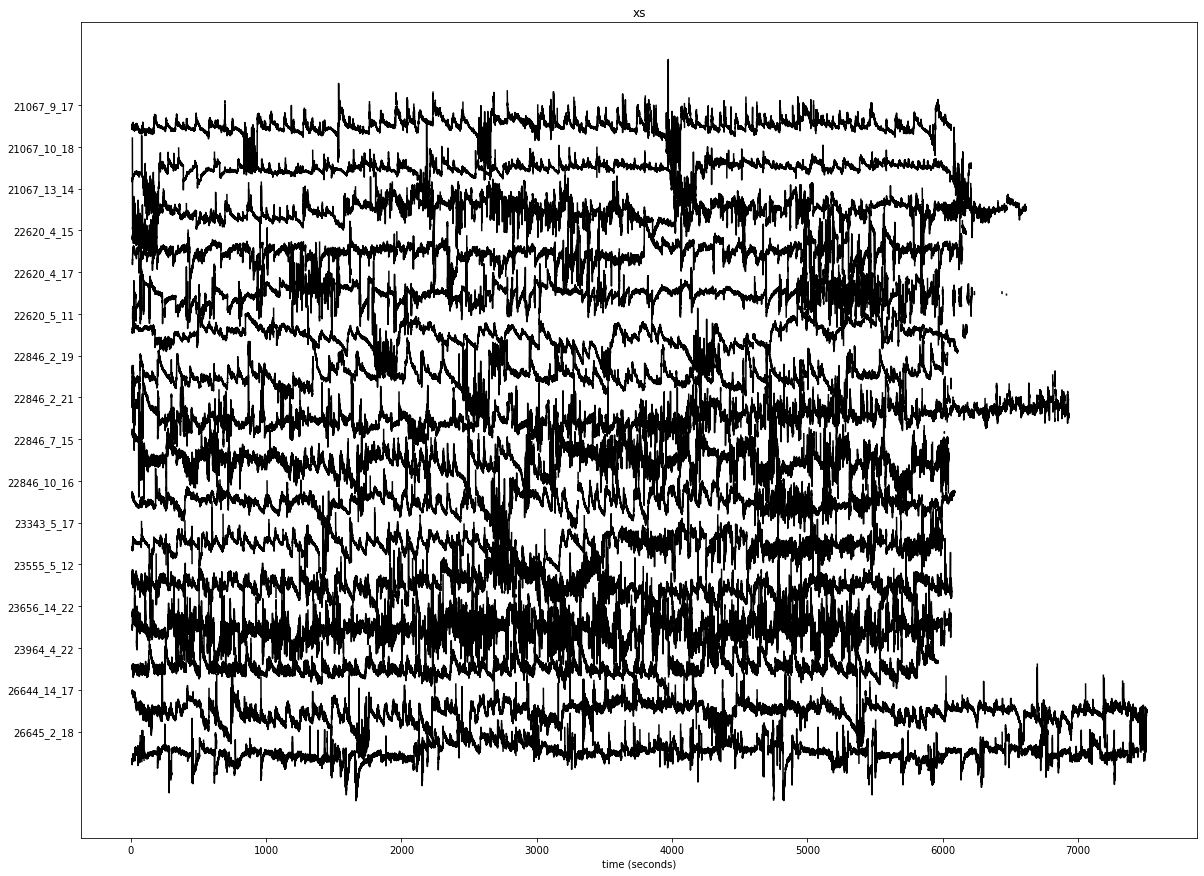

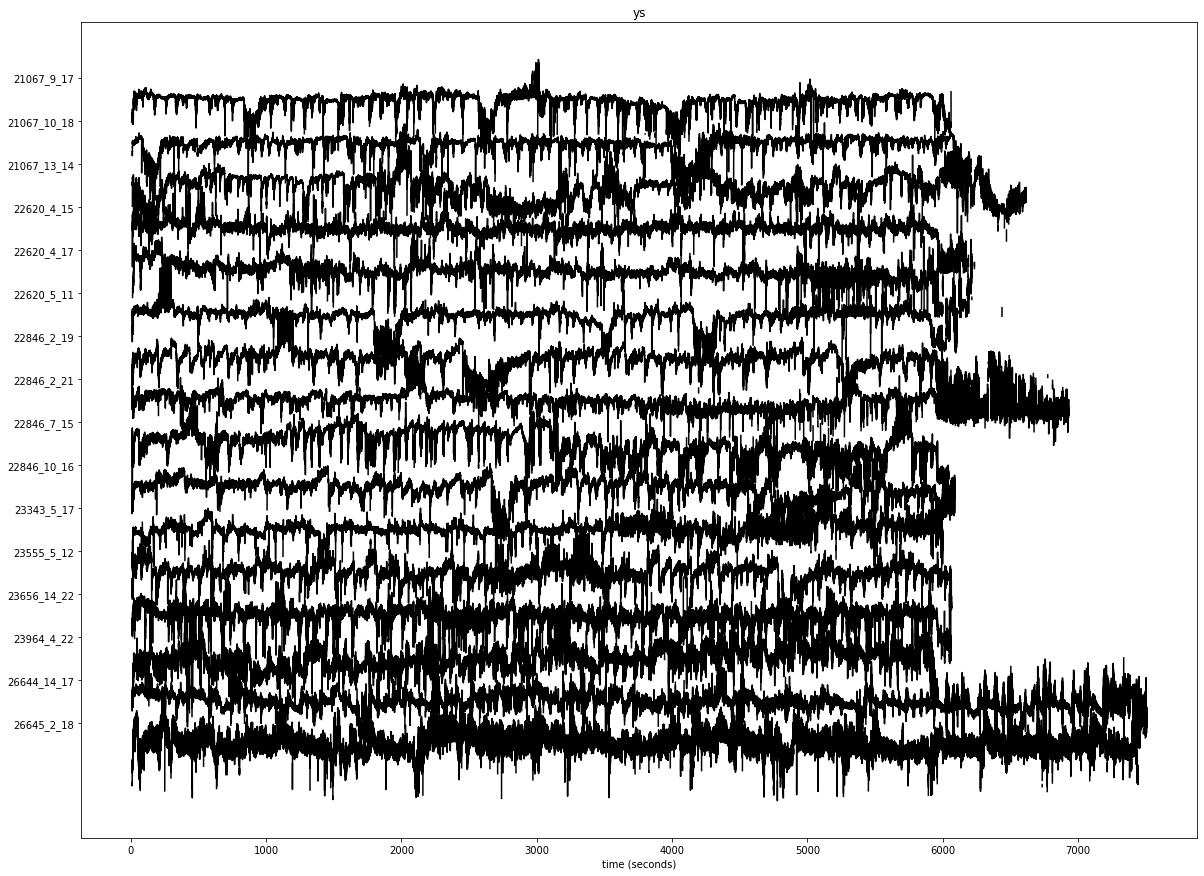

In [38]:
scan_labels = [fit['scan_label'] for fit in fit_df]
for v in ['rs','xs','ys']:
    fig,ax = plt.subplots(figsize=(20,15))
    for i,fit in enumerate(fit_df):
        ax.plot(fit['ts'],fit[v]-i,'k')
    ax.set_yticks(0.5-np.arange(len(scan_labels)))
    ax.set_yticklabels(scan_labels)
    _ = ax.set_xlabel('time (seconds)')
    ax.set_title(v)
    plt.show()
    plt.close()

    
#     ax.set_yticks()
# scan_labels = []
# for i,scan in enumerate(nda.Scan.proj()):
#     ts = np.array((pupil.Eye & scan).fetch1('eye_time'))
#     rs,ids = (pupil.FittedPupil.Circle & scan).fetch('radius','frame_id')    
#     ts -= np.nanmin(ts)
#     ts = ts[ids]
#     rs -= np.nanmin(rs)
#     rs /= np.nanpercentile(rs,99.9)
#     ax.plot(ts,rs-i,'k')
#     scan_labels.append('_'.join([str(s) for s in scan.values()]))
# ax.set_yticks(0.5-np.arange(len(scan_labels)))
# ax.set_yticklabels(scan_labels)
# _ = ax.set_xlabel('time (seconds)')
    
    

# Treadmill

treadmill frequency range:  99.81  -  100.24  Hz


animal_id  session  scan_idx  treadmill_raw_len  treadmill_time_len  \
0       21067        9        17             606100              606100   
1       21067       10        18             621000              621000   
2       21067       13        14             661700              661700   
3       22620        4        15             617100              617100   
4       22620        4        17             648200              648200   
5       22620        5        11             611100              611100   
6       22846        2        19             603500              603500   
7       22846        2        21             693100              693100   
8       22846        7        15             604600              604600   
9       22846       10        16             608900              608900   
10      23343        5        17             600000              600000   
11      23555        5        12             606500              606500   
12      23656       14        22             605700              605700   
13      23964        4        22             596600              596600   
14      26644       14        17             750600              750600   
15      26645        2        18             744100              744100   

    treadmill_vel_len  treadmill_time_freq  
0              606100            99.863187  
1              621000            99.843246  
2              661700            99.813349  
3              617100            99.840256  
4              648200            99.838262  
5              611100            99.853216  
6              603500            99.839259  
7              693100            99.852219  
8              604600            99.846237  
9              608900            99.847234  
10             600000            99.815342  
11             606500            99.859199  
12             605700            99.890121  
13             596600            99.845240  
14             750600           100.222494  
15             744100           100.240577

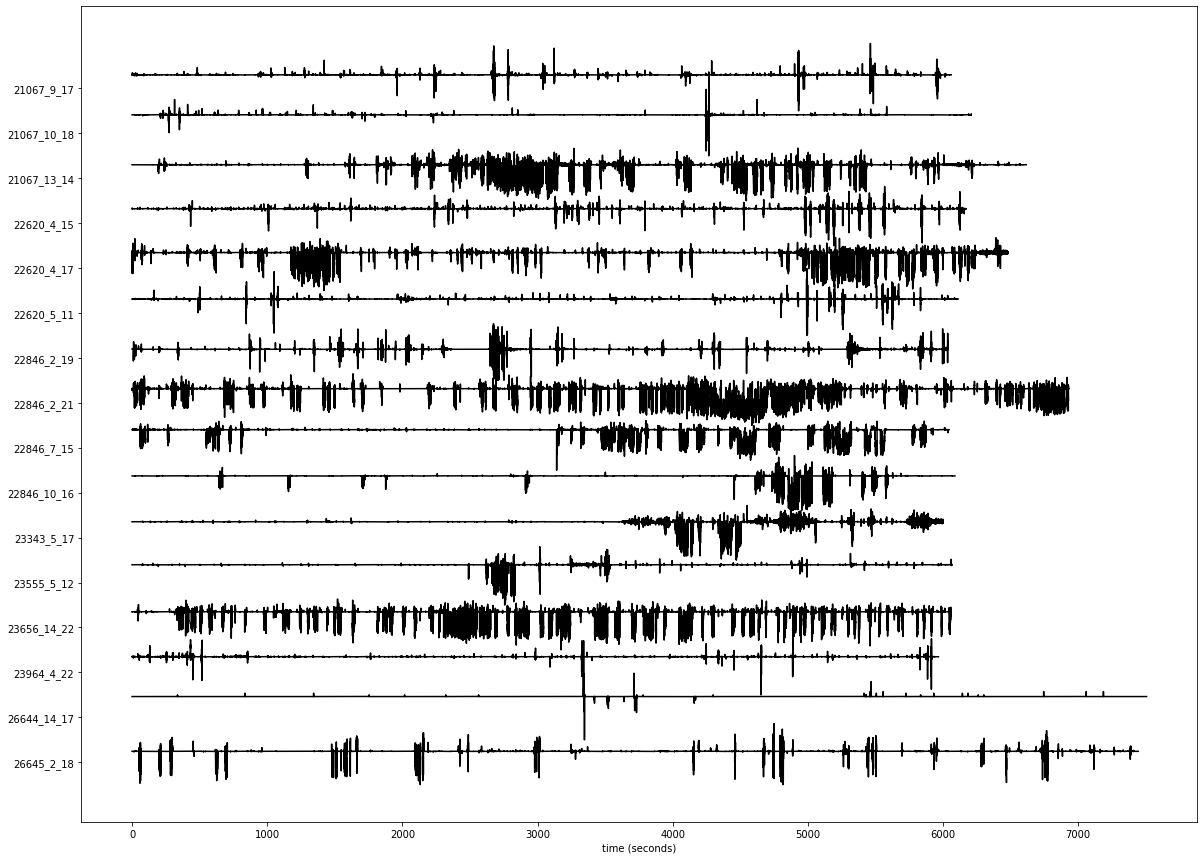

In [46]:
treadmill_df = []
for scan in nda.Scan.proj():
    fetch_str = ['treadmill_raw','treadmill_time','treadmill_vel']
    trs,tts,tvs = (treadmill.Treadmill & scan).fetch1(*fetch_str)
    treadmill_df.append({'animal_id':scan['animal_id'],
                         'session':scan['session'],
                         'scan_idx':scan['scan_idx'],
                         'treadmill_raw_len':len(trs), 
                         'treadmill_time_len':len(tts), 
                         'treadmill_vel_len':len(tvs), 
                         'treadmill_time_freq':1/np.nanmedian(np.diff(tts))})
treadmill_df = pd.DataFrame(treadmill_df)
print('treadmill frequency range: ',
      np.round(np.min(treadmill_df['treadmill_time_freq']),2), ' - ',
      np.round(np.max(treadmill_df['treadmill_time_freq']),2), ' Hz')
display(pd.DataFrame(treadmill_df))


fig,ax = plt.subplots(figsize=(20,15))
scan_labels = []
for i,scan in enumerate(nda.Scan.proj()):
    ts,vs = np.array((treadmill.Treadmill & scan).fetch1('treadmill_time','treadmill_vel'))
    ts -= np.nanmin(ts)
    vs -= np.nanmin(vs)
    vs /= np.nanpercentile(vs,99.9)
    ax.plot(ts,vs-i,'k')
    scan_labels.append('_'.join([str(s) for s in scan.values()]))
ax.set_yticks(0.5-np.arange(len(scan_labels)))
ax.set_yticklabels(scan_labels)
_ = ax.set_xlabel('time (seconds)')